In [18]:
import os
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image


In [19]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.InstanceNorm2d(channels, affine=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, 1, 1),
            nn.InstanceNorm2d(channels, affine=True),
        )

    def forward(self, x):
        return x + self.block(x)

class TransformerNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 32, 9, 1, 4),
            nn.InstanceNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, 3, 2, 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, 3, 2, 1),
            nn.InstanceNorm2d(128),
            nn.ReLU(),

            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),

            nn.ConvTranspose2d(128, 64, 3, 2, 1, 1),
            nn.InstanceNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, 3, 2, 1, 1),
            nn.InstanceNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 3, 9, 1, 4),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)


In [20]:
class VGGFeatures(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.DEFAULT).features
        self.slice = nn.Sequential(*list(vgg.children())[:23])
        for param in self.slice.parameters():
            param.requires_grad = False

    def forward(self, x):
        features = []
        for layer in self.slice:
            x = layer(x)
            if isinstance(layer, nn.ReLU):
                features.append(x)
        return features

def gram_matrix(x):
    b, c, h, w = x.size()
    features = x.view(b, c, h * w)
    G = torch.bmm(features, features.transpose(1, 2))
    return G / (c * h * w)

def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(tensor.device)
    std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(tensor.device)
    return tensor * std + mean


In [21]:
image_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

dataset = ImageFolder("resized_output", transform=image_transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


In [22]:
def load_image(path):
    image = Image.open(path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    return transform(image).unsqueeze(0)

style_image = load_image("style Image.jpg").cuda()


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer = TransformerNet().to(device)
vgg = VGGFeatures().to(device)
optimizer = optim.Adam(transformer.parameters(), lr=1e-3)
mse_loss = nn.MSELoss()

style_features = vgg(style_image)
style_grams = [gram_matrix(f) for f in style_features]

os.makedirs("stylized_training_output", exist_ok=True)

epochs = 600
save_interval = 25  

print("Training started...")
step = 0
for epoch in range(epochs):
    for i, (x, _) in enumerate(dataloader):
        print("Your model has trained this much epoch ", epoch+1)
        x = x.to(device)
        y_hat = transformer(x)
        y_features = vgg(y_hat)
        x_features = vgg(x)

        content_loss = mse_loss(y_features[2], x_features[2])
        style_loss = sum(mse_loss(gram_matrix(f1), f2.expand_as(gram_matrix(f1)))
                         for f1, f2 in zip(y_features, style_grams))
        total_loss = content_loss + 70 * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if step % save_interval == 0:
            output = denormalize(y_hat.clone())
            save_image(output, f"stylized_training_output/epoch{epoch+1}_batch{i+1}.jpg")

        step += 1

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss.item():.4f}")

torch.save(transformer.state_dict(), "final_styled_model.pth")
print("Model saved.")


Training started...
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has trained this much epoch  1
Your model has

In [23]:
# Load model
transformer = TransformerNet().to(device)
transformer.load_state_dict(torch.load("final_styled_model.pth"))
transformer.eval()

# Load new image
def stylize_image(input_path, output_path):
    image = Image.open(input_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    x = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        y = transformer(x)
    y = denormalize(y)
    save_image(y, output_path)

stylize_image("Testing6.jpg", "stylized_output4.jpg")


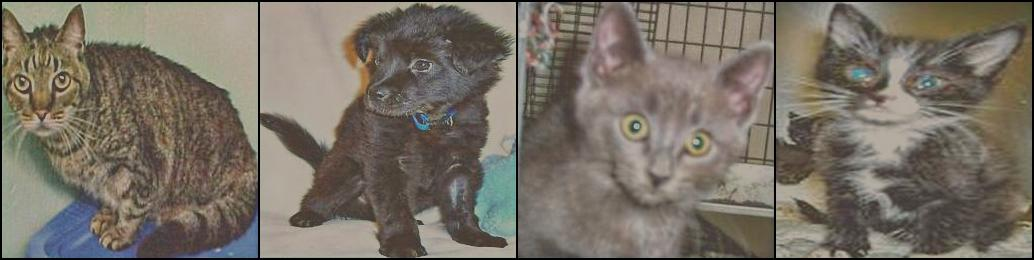

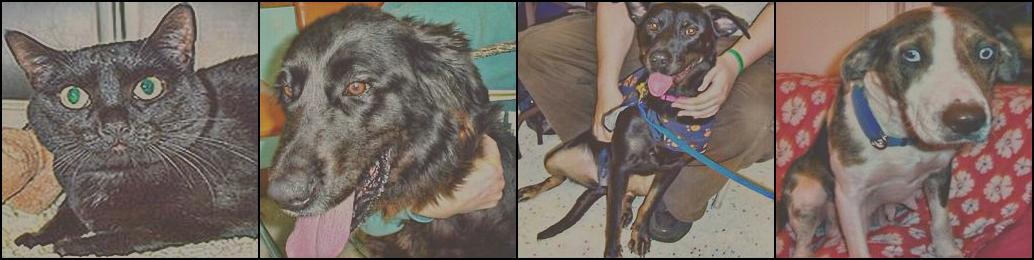

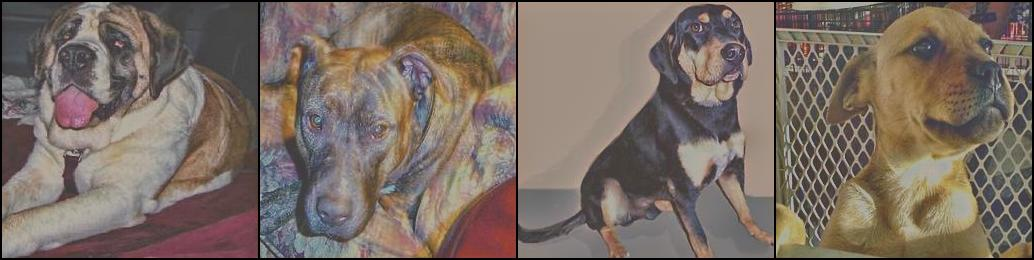

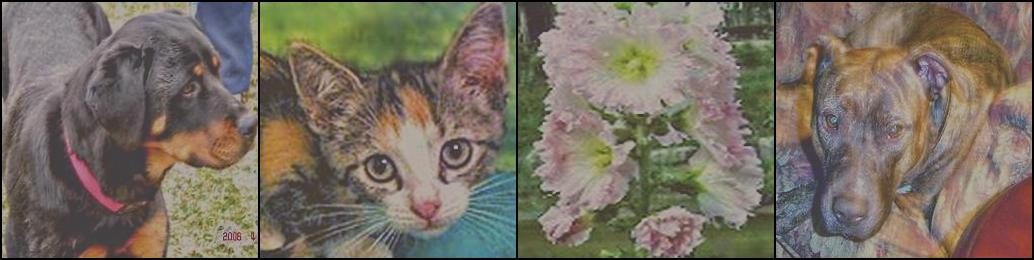

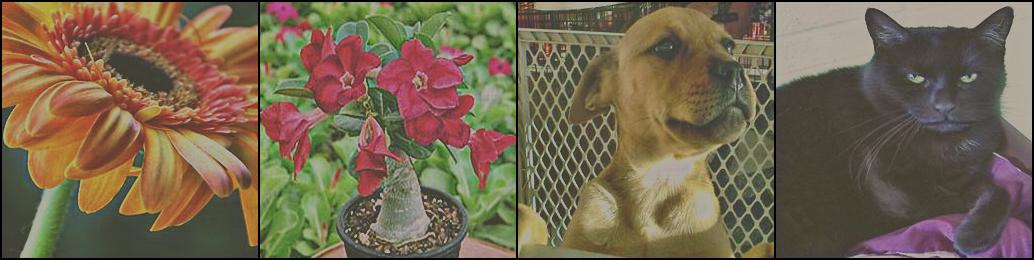

In [14]:
import os
from IPython.display import Image, display

image_folder = "stylized_training_output"
images = sorted(os.listdir(image_folder))  # You can use sorted for sequential viewing

# View first 5 images
for img_file in images[:5]:
    display(Image(filename=os.path.join(image_folder, img_file)))


In [ ]:
def save_image(tensor, output_path):
    tensor = tensor.clone().detach().cpu().squeeze(0)
    tensor = (tensor + 1) / 2 
    tensor = tensor.clamp(0, 1)
    image = transforms.ToPILImage()(tensor)
    image.save(output_path)


In [25]:
import torch
from torchvision import transforms
from PIL import Image
from model import TransformerNet  # Make sure model.py is in the same folder

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
transformer = TransformerNet().to(device)
transformer.load_state_dict(torch.load("final_styled_model.pth", map_location=device))
transformer.eval()

# Function to reverse normalization for saving
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)
    return tensor * std + mean

# Save image to file
def save_image(tensor, path):
    image = tensor.clone().detach().cpu().squeeze(0)
    image = image.clamp(0, 1)
    image = transforms.ToPILImage()(image)
    image.save(path)

# Load new image and apply style
def stylize_image(input_path, output_path):
    image = Image.open(input_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
    x = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        y = transformer(x)

    y = denormalize(y)
    save_image(y, output_path)

# Example use
stylize_image("Testing6.jpg", "stylized_output4.jpg")


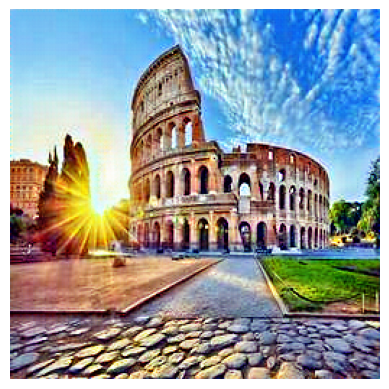

In [26]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from PIL import Image
import torch
import torchvision.transforms.functional as TF
from model import TransformerNet  # Make sure model definition is available
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
model = TransformerNet()
model.load_state_dict(torch.load("final_styled_model.pth", map_location=device))
model.to(device)
model.eval()

# Load and preprocess input image
img = Image.open("Testing.jpg").convert("RGB")
transform = Compose([
    Resize(256),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406],
              [0.229, 0.224, 0.225])
])
input_tensor = transform(img).unsqueeze(0).to(device)

# Stylize
with torch.no_grad():
    output = model(input_tensor).cpu().squeeze(0)
    output = torch.clamp(output * 0.5 + 0.5, 0, 1)  # Denormalize

# Show
plt.imshow(output.permute(1, 2, 0))
plt.axis('off')
plt.show()


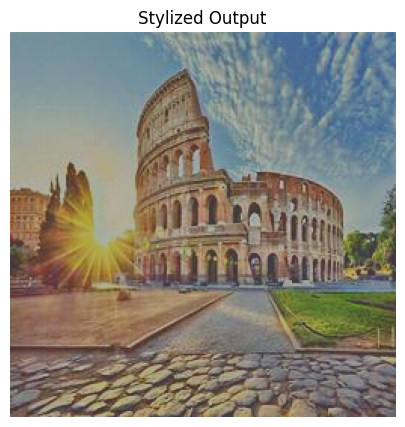

Stylized image saved as stylized_result.jpg


In [27]:
import torch
from torchvision.transforms import Compose, ToTensor, Normalize, Resize
from PIL import Image
import matplotlib.pyplot as plt
from model import TransformerNet  # make sure this is the same model you used for training
import torchvision.transforms.functional as TF

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load trained model
model = TransformerNet()
model.load_state_dict(torch.load("final_styled_model.pth", map_location=device))
model.to(device)
model.eval()

# Load test image
img_path = "Testing.jpg"  # change this to your test image path
image = Image.open(img_path).convert("RGB")

# Transform image
transform = Compose([
    Resize(256),
    ToTensor(),
    Normalize([0.485, 0.456, 0.406],
              [0.229, 0.224, 0.225])
])
input_tensor = transform(image).unsqueeze(0).to(device)

# Stylize
with torch.no_grad():
    output_tensor = model(input_tensor).cpu().squeeze(0)

# Denormalize
output_tensor = torch.clamp(output_tensor * 0.229 + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1), 0, 1)

# Show the output
plt.figure(figsize=(10, 5))
plt.imshow(output_tensor.permute(1, 2, 0).numpy())
plt.axis('off')
plt.title("Stylized Output")
plt.show()

# Save output
output_image = TF.to_pil_image(output_tensor)
output_image.save("stylized_result.jpg")
print("Stylized image saved as stylized_result.jpg")


In [28]:
from torchvision.utils import save_image
import torch
from PIL import Image
import torchvision.transforms as transforms
from model import TransformerNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TransformerNet().to(device)
model.load_state_dict(torch.load("final_styled_model.pth", map_location=device))
model.eval()

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

image = Image.open("Testing.jpg").convert("RGB")
x = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    y = model(x)

# Calculate difference
diff = torch.abs(x - y).mean()
print(f"Mean pixel difference: {diff.item():.6f}")


Mean pixel difference: 0.565616
